In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
 

某一层的输出，进行四条路径下不同的处理，有1*1卷积、3*3卷积、5*5卷积以及3*3池化等操作，再最终将结果合并到一起。这就是最早期inception块的思路

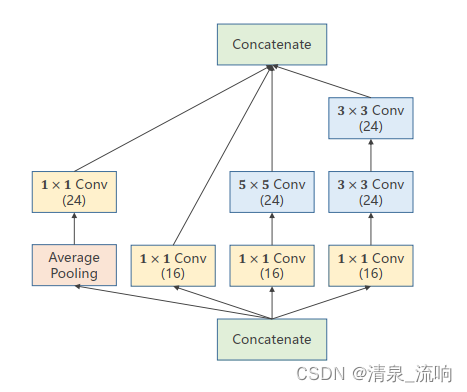

In [2]:
# prepare dataset
 
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])  # 归一化,均值和方差
 
train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='../dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
 
 
# design model using class
class InceptionA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)  # 2维卷积
 
        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
 
        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
 
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
 
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
 
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
 
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)
 
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
 
        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, dim=1)  # b,c,w,h  c对应的是dim=1
 
 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(88, 20, kernel_size=5)  # 88 = 24x3 + 16
 
        self.incep1 = InceptionA(in_channels=10)  # 与conv1 中的10对应
        self.incep2 = InceptionA(in_channels=20)  # 与conv2 中的20对应
 
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(1408, 10)
 
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = self.incep1(x)
        x = F.relu(self.mp(self.conv2(x)))
        x = self.incep2(x)
        x = x.view(in_size, -1)
        x = self.fc(x)
 
        return x
 
 
model = Net()
 
# construct loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
 
 
# training cycle forward, backward, update
 
 
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
 
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0
 
 
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy on test set: %d %% ' % (100 * correct / total))
 
 

100%|██████████| 9912422/9912422 [00:00<00:00, 83921655.44it/s]


Extracting ../dataset/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../dataset/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62473282.01it/s]

Extracting ../dataset/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../dataset/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22491508.30it/s]


Extracting ../dataset/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../dataset/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14238063.35it/s]


Extracting ../dataset/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../dataset/mnist/MNIST/raw



In [3]:
for epoch in range(10):
    train(epoch)
    test()

[1,   300] loss: 0.944
[1,   600] loss: 0.224
[1,   900] loss: 0.141
accuracy on test set: 96 % 
[2,   300] loss: 0.111
[2,   600] loss: 0.097
[2,   900] loss: 0.089
accuracy on test set: 97 % 
[3,   300] loss: 0.076
[3,   600] loss: 0.076
[3,   900] loss: 0.069
accuracy on test set: 98 % 
[4,   300] loss: 0.058
[4,   600] loss: 0.063
[4,   900] loss: 0.059
accuracy on test set: 98 % 
[5,   300] loss: 0.054
[5,   600] loss: 0.050
[5,   900] loss: 0.058
accuracy on test set: 98 % 
[6,   300] loss: 0.045
[6,   600] loss: 0.049
[6,   900] loss: 0.047
accuracy on test set: 98 % 
[7,   300] loss: 0.041
[7,   600] loss: 0.044
[7,   900] loss: 0.045
accuracy on test set: 98 % 
[8,   300] loss: 0.038
[8,   600] loss: 0.041
[8,   900] loss: 0.041
accuracy on test set: 98 % 
[9,   300] loss: 0.038
[9,   600] loss: 0.037
[9,   900] loss: 0.038
accuracy on test set: 98 % 
[10,   300] loss: 0.035
[10,   600] loss: 0.030
[10,   900] loss: 0.037
accuracy on test set: 98 % 
